## 1 Bringing in our Data

The following cells should be starting to look familiar to you - I'm not going to annotate them here.  They a) bring in our libraries, b) read in our .csv file, c) rename our variables, and d) create our dummy variables for our analysis.

In [1]:
#Call our libraries; note, we are adding some libraries to our notebook

import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import t
from datascience import *

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

pd.options.display.float_format = '{:.4f}'.format

In [2]:
person_df=pd.read_csv("sf_acs_pums_p.csv") #MergingData/
person_df.head()

,serialno,sporder,wagp,occp,rac1p,fhisp
0,2013000000240,1,50000.0000,220.0000,1,0
1,2013000000253,1,7400.0000,2340.0000,1,0
2,2013000000253,2,80000.0000,1320.0000,1,0
3,2013000000253,3,0.0000,2010.0000,1,0
4,2013000000253,4,9000.0000,2340.0000,1,0


In [3]:
person_df.rename(columns={"sporder":"p_number",
                          "wagp":"wages",
                          "occp":"occupation",
                          "rac1p":"race",
                          "fhisp":"hispanic"}, inplace=True)
person_df.head()

,serialno,p_number,wages,occupation,race,hispanic
0,2013000000240,1,50000.0000,220.0000,1,0
1,2013000000253,1,7400.0000,2340.0000,1,0
2,2013000000253,2,80000.0000,1320.0000,1,0
3,2013000000253,3,0.0000,2010.0000,1,0
4,2013000000253,4,9000.0000,2340.0000,1,0


In [4]:
housingunit_df=pd.read_csv("sf_acs_pums_h.csv") #MergingData/
housingunit_df.head()

,serialno,bld,rntp,ybl
0,2013000000253,6,2100,1
1,2013000000916,8,1100,1
2,2013000000982,8,1600,2
3,2013000002424,2,3000,1
4,2013000002555,5,1700,2


In [5]:
housingunit_df.rename(columns={"bld":"buildingsize",
                               "rntp":"rent",
                               "ybl":"yearbuilt"}, inplace=True)
housingunit_df.head()

,serialno,buildingsize,rent,yearbuilt
0,2013000000253,6,2100,1
1,2013000000916,8,1100,1
2,2013000000982,8,1600,2
3,2013000002424,2,3000,1
4,2013000002555,5,1700,2


## 2 Merging Data

### 2.1 Figuring Out What You're Merging

We general merge on a ***key*** or common variable.  In this case, both datasets have a serialno, which is the identifier associated with the housing unit that the census sampled in conducting their ACS survey.  When you look at the HousingUnit dataset, you see each serialno is unique.  But in the person dataset, you have four rows of the serial number 2013000000253 - one for each person in the household, which is indicated by the person number. 

The options for merging are:

a ***one to one merge***: this is when both files have only one observation per key variable, for example, both datafiles contain aggregate data at the tract FIPS level, and you want to merge by the census tract FIPS.

a ***one to many merge***: this is when you want merge a dataset with one observation per key value to one with more observations.  A good example here is if I want to attach the data on the housing unit (**one** record per unit) to every person in the dataset (**many** people per unit). 

a ***many to one merge***: this is when you want to mrege a dataset with many observations per key value to one with just a single observation. A good example here is if I want to attach the data on the people (**many** records per unit) to every housing unit in the dataset (**one** per unit). 

Let's look at the code for all three and see what happens!

### 2.2 Merging One to One

First, let's look at the easiest scenario - we just want to merge one to one!  In our practice data, I'm going to drop everyone but the head of household, so I have the same number of observations of my key variable for my housing units and my person file.

In [6]:
# Here I drop the rows (index) where the person variable in the person_df is not equal to 1
# I'm going to rename the dataframe so I can use the "raw" person data later.
head_df=person_df.drop(person_df[person_df['p_number'] != 1].index)
head_df.head()

,serialno,p_number,wages,occupation,race,hispanic
0,2013000000240,1,50000.0000,220.0000,1,0
1,2013000000253,1,7400.0000,2340.0000,1,0
5,2013000000637,1,50000.0000,1050.0000,6,0
11,2013000000857,1,74000.0000,2310.0000,2,0
12,2013000000916,1,50000.0000,4110.0000,1,0


In [7]:
pums_person_unit_df=pd.merge(head_df, housingunit_df, on="serialno")
pums_person_unit_df.head()

,serialno,p_number,wages,occupation,race,hispanic,buildingsize,rent,yearbuilt
0,2013000000253,1,7400.0000,2340.0000,1,0,6,2100,1
1,2013000000916,1,50000.0000,4110.0000,1,0,8,1100,1
2,2013000000982,1,64000.0000,2830.0000,8,0,8,1600,2
3,2013000002424,1,5000.0000,2340.0000,1,0,2,3000,1
4,2013000002555,1,100000.0000,120.0000,1,0,5,1700,2


### 2.3 One to Many Merge

This time, I want to add the "housing unit" information to every person in my dataset.  (For example, if I want to know if children are more likely to live in single-family versus larger apartment buildings, I might want to know what kind of building every child in the dataset lives in.)

Honestly, merging is the first function I've found in Python that's easier than in SAS or STATA!!

In [8]:
personwithhousing_df=pd.merge(person_df, housingunit_df, on="serialno")
personwithhousing_df.head(20)

,serialno,p_number,wages,occupation,race,hispanic,buildingsize,rent,yearbuilt
0,2013000000253,1,7400.0000,2340.0000,1,0,6,2100,1
1,2013000000253,2,80000.0000,1320.0000,1,0,6,2100,1
2,2013000000253,3,0.0000,2010.0000,1,0,6,2100,1
3,2013000000253,4,9000.0000,2340.0000,1,0,6,2100,1
4,2013000000916,1,50000.0000,4110.0000,1,0,8,1100,1
5,2013000000916,2,90000.0000,350.0000,1,0,8,1100,1
6,2013000000982,1,64000.0000,2830.0000,8,0,8,1600,2
7,2013000002424,1,5000.0000,2340.0000,1,0,2,3000,1
8,2013000002424,2,70000.0000,1360.0000,1,0,2,3000,1
9,2013000002424,3,0.0000,1010.0000,1,0,2,3000,1


### 2.4 OK - What about Many to One?

In general, we want to "group by" first - for example, I want to know how many people are in the housing unit.  But let's say I really just want to attach all the people to each housing unit.  I can just swap the order of the merge.  But, in reality, this just looks like my one to many merge above, it's just that the first columns contain the building information rather than the person information.

In [9]:
housing_allpeeps_df=pd.merge(housingunit_df, person_df, on="serialno")
housing_allpeeps_df.head(20)

,serialno,buildingsize,rent,yearbuilt,p_number,wages,occupation,race,hispanic
0,2013000000253,6,2100,1,1,7400.0000,2340.0000,1,0
1,2013000000253,6,2100,1,2,80000.0000,1320.0000,1,0
2,2013000000253,6,2100,1,3,0.0000,2010.0000,1,0
3,2013000000253,6,2100,1,4,9000.0000,2340.0000,1,0
4,2013000000916,8,1100,1,1,50000.0000,4110.0000,1,0
5,2013000000916,8,1100,1,2,90000.0000,350.0000,1,0
6,2013000000982,8,1600,2,1,64000.0000,2830.0000,8,0
7,2013000002424,2,3000,1,1,5000.0000,2340.0000,1,0
8,2013000002424,2,3000,1,2,70000.0000,1360.0000,1,0
9,2013000002424,2,3000,1,3,0.0000,1010.0000,1,0


## 3 Grouping "by" to Get New Data

More often, we want to group a number of observations by a certain characteristic.  For example, in this case, I might want to know the number of people in the household.  Others of you will want to count how many evictions or traffic accidents are happening in a census tract or zip code.  Once I merge the data, I can "aggregate" the information using the same "group by" concept we used when we were calculating descriptive statistics.

In [10]:
#In this code, I start by grouping my data by unit, or serialno
#Altnerately, you could do this by fips tract
df_by_unit=housing_allpeeps_df.groupby("serialno")

In [11]:
# Now, I'm going to tell Python how I want to aggregate the various columns,
# as well as what I want the new variable to be named
housing_allpeeps_df["hh_size"] = df_by_unit["p_number"].transform("count")
housing_allpeeps_df["total_wages"] =df_by_unit["wages"].transform("sum")
housing_allpeeps_df.head(20)

,serialno,buildingsize,rent,yearbuilt,p_number,wages,occupation,race,hispanic,hh_size,total_wages
0,2013000000253,6,2100,1,1,7400.0000,2340.0000,1,0,4,96400.0000
1,2013000000253,6,2100,1,2,80000.0000,1320.0000,1,0,4,96400.0000
2,2013000000253,6,2100,1,3,0.0000,2010.0000,1,0,4,96400.0000
3,2013000000253,6,2100,1,4,9000.0000,2340.0000,1,0,4,96400.0000
4,2013000000916,8,1100,1,1,50000.0000,4110.0000,1,0,2,140000.0000
5,2013000000916,8,1100,1,2,90000.0000,350.0000,1,0,2,140000.0000
6,2013000000982,8,1600,2,1,64000.0000,2830.0000,8,0,1,64000.0000
7,2013000002424,2,3000,1,1,5000.0000,2340.0000,1,0,3,75000.0000
8,2013000002424,2,3000,1,2,70000.0000,1360.0000,1,0,3,75000.0000
9,2013000002424,2,3000,1,3,0.0000,1010.0000,1,0,3,75000.0000


### 3.1 Dropping Duplicates

In [12]:
# Now, if I want to remove the duplicates, I can run my code to just select the head of household
# Notice the conditional statement (boolean) in this code. Take a moment to talk through this line of code with
# a neighbor, and describe what we're telling Python with each command.

pums_data=housing_allpeeps_df.drop(housing_allpeeps_df[housing_allpeeps_df['p_number'] != 1].index).copy()
pums_data.head()

,serialno,buildingsize,rent,yearbuilt,p_number,wages,occupation,race,hispanic,hh_size,total_wages
0,2013000000253,6,2100,1,1,7400.0000,2340.0000,1,0,4,96400.0000
4,2013000000916,8,1100,1,1,50000.0000,4110.0000,1,0,2,140000.0000
6,2013000000982,8,1600,2,1,64000.0000,2830.0000,8,0,1,64000.0000
7,2013000002424,2,3000,1,1,5000.0000,2340.0000,1,0,3,75000.0000
10,2013000002555,5,1700,2,1,100000.0000,120.0000,1,0,1,100000.0000


## 4 Order of Operations

I generally clean and create dummies, make new categories, of each dataset before I merge them. A best practice is to first write out what steps you need to do before you do them, and then think about the logical approach to coding. And, I often make mistakes and have to go back, but luckily I have all my code so it goes faster as I make fixes to get to the analysis I want!

## 5 Dropping Values

The .drop() function allows us to drop columns, rows, or values from a dataframe. We can also specify conditional statements like we did up above.

### 5.1 Dropping Null Values

In [13]:
# This lets us know if there are any null values
print( pums_data.isnull().values.any() ) 

# This shows us the total number of missing values for each variable
print( pums_data.isnull().sum() ) 

True
serialno           0
buildingsize       0
rent               0
yearbuilt          0
p_number           0
wages              0
occupation      1395
race               0
hispanic           0
hh_size            0
total_wages        0
dtype: int64


In [14]:
# The '.dropna' function drops values that Python recognizes as missing.
pums_data.dropna(inplace=True)

print( pums_data.isnull().sum() ) 

serialno        0
buildingsize    0
rent            0
yearbuilt       0
p_number        0
wages           0
occupation      0
race            0
hispanic        0
hh_size         0
total_wages     0
dtype: int64


### 5.2 Dropping a Column

In [15]:
# This code drops the wages column, so we don't get confused about which wage variable to use in this dataframe.
# To drop more than one column, simply list the column labes in square brackets: ['wages', 'occupation', etc.]
pums_data.drop('wages', axis=1, inplace=True)

pums_data.head()

,serialno,buildingsize,rent,yearbuilt,p_number,occupation,race,hispanic,hh_size,total_wages
0,2013000000253,6,2100,1,1,2340.0000,1,0,4,96400.0000
4,2013000000916,8,1100,1,1,4110.0000,1,0,2,140000.0000
6,2013000000982,8,1600,2,1,2830.0000,8,0,1,64000.0000
7,2013000002424,2,3000,1,1,2340.0000,1,0,3,75000.0000
10,2013000002555,5,1700,2,1,120.0000,1,0,1,100000.0000


### 5.3 Dropping a Row (Using a Conditional Statement)

In [16]:
# Let's say we want to know more about household size. Let's take a quick look at that variable.
pums_data['hh_size'].describe()

count   6607.0000
mean       2.1747
std        1.2841
min        1.0000
25%        1.0000
50%        2.0000
75%        3.0000
max       14.0000
Name: hh_size, dtype: float64

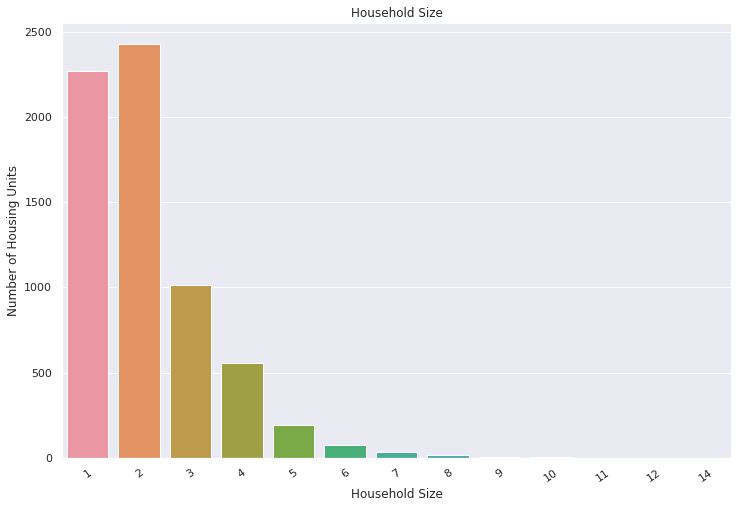

In [17]:
# Woah - 14 is a lot of people! Let's take a closer look to see if this is an outlier.

# Sneak peak of the code in the optional notebook we've put together with more resources. Check it out!

# Here we are defining a function (called hh_size_histogram) which runs all of the code we tell it to. 
# Defining our own functions just makes it easier to get the same output later. 
# We're also using a couple new libraries to plot a histogram.

def hh_size_histogram ():
    sns.set()
    plt.figure(figsize=(12,8))
    plt.title("Household Size")
    plt.xticks(rotation=35)
    sns.countplot(pums_data['hh_size'])
    plt.ylabel("Number of Housing Units")
    plt.xlabel("Household Size")
    plt.show()
    
hh_size_histogram()

In [18]:
# Let's go ahead and drop household sizes over 10 people. 
# Keep in mind there are many ways to get the same result in Python. What would be another option here?

pums_data.drop( pums_data[pums_data['hh_size'] > 10].index, inplace=True )

In [19]:
# Let's take a look at this variable in our dataframe to see what this did.

pums_data['hh_size'].describe()

count   6603.0000
mean       2.1686
std        1.2600
min        1.0000
25%        1.0000
50%        2.0000
75%        3.0000
max       10.0000
Name: hh_size, dtype: float64

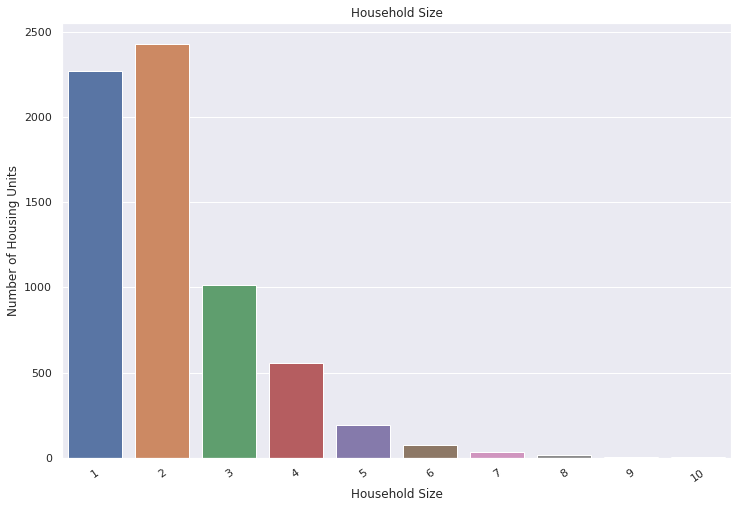

In [20]:
hh_size_histogram()

# 6 Data Binning
Sometimes it can be useful to change a continuous variable into a categorical one. This is called 'binning.'

In [23]:
# Let's take a look at the distribution of our total wages
pums_data["total_wages"].describe()

count      6603.0000
mean     117071.8037
std      116806.2535
min           0.0000
25%       34000.0000
50%       90000.0000
75%      163000.0000
max     1008000.0000
Name: total_wages, dtype: float64

In [22]:
pums_data["total_wages"].quantile([0,.2,.4,.6,.8,.99])

0.0000        0.0000
0.2000    24000.0000
0.4000    65000.0000
0.6000   115000.0000
0.8000   187000.0000
0.9900   553980.0000
Name: total_wages, dtype: float64

In [27]:
# Defining bin cutoffs
wage_bins = ( 0, 25000, 50000, 100000, 150000, 1008000 )
             # Far left number is minimum, far right number is maximum value

# Defining bin labels
bin_labels = ( 'Very Low Wage', 'Low Wage', 'Moderate Wage', 'High Wage', 'Very High Warnings')

# Defining a new variable 'monthly earnings'
pums_data['wage_brackets'] = pd.cut( pums_data['total_wages'], wage_bins, labels=bin_labels )
# Tip: Hold down shift and tab, and click on the command 'cut' to see more instructions from Python!

In [28]:
pums_data.head()

,serialno,buildingsize,rent,yearbuilt,p_number,occupation,race,hispanic,hh_size,total_wages,wage_brackets
0,2013000000253,6,2100,1,1,2340.0000,1,0,4,96400.0000,Moderate Wage
4,2013000000916,8,1100,1,1,4110.0000,1,0,2,140000.0000,High Wage
6,2013000000982,8,1600,2,1,2830.0000,8,0,1,64000.0000,Moderate Wage
7,2013000002424,2,3000,1,1,2340.0000,1,0,3,75000.0000,Moderate Wage
10,2013000002555,5,1700,2,1,120.0000,1,0,1,100000.0000,Moderate Wage
